In [1]:
import datetime
import numpy as np
import pandas as pd
import os
from os import listdir
from datetime import date
import matplotlib.pyplot as plt
from os.path import isfile, join

In [2]:
# Toplevel log file directories
gsi_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/gsi/logs"
troxel_log_dir = "/Users/gwilliams/Projects/Gemini_Tamu/raw_data/troxel/GSI_Testing"


In [3]:
# choose experiment dirs

# RUN!
gsi_exp_dir = os.path.join( gsi_log_dir, "RUN1_ARGON_LET6.7_" )
troxel_exp_dir = os.path.join( troxel_log_dir, "Run_1")
fname = "Run 1"

# RUN2
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN2_LET6.7" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_2")

# RUN3
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN3_LET6.7" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_3")

# RUN18
#gsi_exp_dir = os.path.join( gsi_log_dir, "RUN18_LET60" )
#troxel_exp_dir = os.path.join( troxel_log_dir, "Run_18")
#fname = "Run 18"

# RUN20
gsi_exp_dir = os.path.join( gsi_log_dir, "RUN19_FUNCTIONALCHECK" )
troxel_exp_dir = os.path.join( troxel_log_dir, "Run_19")
fname = "Run 19"

In [4]:
# locate search logging file
files = [f for f in listdir(gsi_exp_dir) if isfile(join(gsi_exp_dir, f))]
for i in range(len(files)):
    if files[i][0:6] == 'SEARCH':
        file = files[i]
        break
file = gsi_exp_dir + '/' + file
with open(file) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

# get time data
for i in range(len(content)):
    if content[i][0:4] == '2019':
        content = content[i:]
        break
        
# break time-stamped data into a multi-dimensional array        
search = []        
for i in range(len(content)):
    temp = content[i].split()
    date_time_str = temp[0] + ' ' + temp[1]
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
    date = date_time_obj.date()
    time = date_time_obj.time()
    col3 = ''
    for i in range(len(temp[2:])):
        col3 = col3 + temp[i+2] + ' '
    col3 = col3[:-1]
    item = [date_time_obj, date, time, col3]
    search.append(item)

# create pandas dataframe with time-stamped data
df = pd.DataFrame(search) 
df.head(10)

,0,1,2,3
0,2019-11-25 00:54:14.242363,2019-11-25,00:54:14.242363,before gnl setup
1,2019-11-25 00:54:14.242381,2019-11-25,00:54:14.242381,1
2,2019-11-25 00:54:15.268865,2019-11-25,00:54:15.268865,2
3,2019-11-25 00:54:15.268922,2019-11-25,00:54:15.268922,3
4,2019-11-25 00:54:15.268930,2019-11-25,00:54:15.268930,4
5,2019-11-25 00:54:15.283375,2019-11-25,00:54:15.283375,5
6,2019-11-25 00:54:15.295018,2019-11-25,00:54:15.295018,6
7,2019-11-25 00:54:15.295052,2019-11-25,00:54:15.295052,after gnl setup
8,2019-11-25 00:54:25.012800,2019-11-25,00:54:25.012800,searching knn_hamming !!!!!!!!!!!
9,2019-11-25 00:54:29.170926,2019-11-25,00:54:29.170926,search duration: 4.1581220626831055


In [5]:
# Get duration and num data points...
times = df[2].tolist()
def get_time(beginning, end):
    t = datetime.datetime.combine(date.min, end) - datetime.datetime.combine(date.min, beginning)
    return t

t_seconds = []
for i in range(len(times)):
    t_seconds.append(get_time(times[0],times[i]))
    t_seconds[i] = t_seconds[i].total_seconds()
    
t_max = round(max(t_seconds), 2)
print('log file duration: ' + str(t_max) + ' seconds')

logs = df[3].tolist()
logs = [logs[i][:20] for i in range(len(logs))]

print(str(len(logs)) + ' data points recorded!')

log file duration: 31.48 seconds
19 data points recorded!


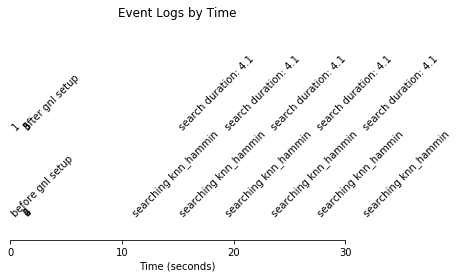

In [6]:
# plot search logs
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

lim = len(t_seconds)
mult = 5
#Max = t_seconds[lim*mult]
Max = t_seconds[len(t_seconds)-1]
interval = Max/10 + 10 - (Max/10)%10

def addtext(i,time, log, ax, props):
    if i%2 == 0:
        ax.text(time, 0.1, log, props, rotation=45)
    else:
        ax.text(time, 0.5, log, props, rotation=45)
    ax.grid(False)

fig, ax = plt.subplots() #figsize=(20,5))

for i in range(lim):
    addtext(i,t_seconds[i], logs[i], ax, {'ha': 'left', 'va': 'bottom'})

ax.set_xticks(np.arange(0, Max, interval), [])
ax.set_xlabel('Time (seconds)')

## begone the right, left, top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.yticks([], [])
ax.set_yticklabels([])
plt.title('Event Logs by Time')
f = plt.show

In [7]:
# Parse the power log file
troxel_test_file = os.path.join( troxel_exp_dir, '2 E36313A 192.168.10.10.CSV' )
troxel_data = pd.read_csv(troxel_test_file) 
troxel_data = troxel_data.iloc[8:]
troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
troxel_data.head(10)

,Time (s),I2 (DC Current),V2 (DC Volt)
8,2019-11-24 16:53:28.160,-2E-06,0.002383
9,2019-11-24 16:53:28.901,0,0.002383
10,2019-11-24 16:53:29.356,-1E-06,0.002383
11,2019-11-24 16:53:29.811,-2E-06,0.002383
12,2019-11-24 16:53:30.267,-1E-06,0.002383
13,2019-11-24 16:53:30.722,-2E-06,0.002383
14,2019-11-24 16:53:31.177,-1E-06,0.002383
15,2019-11-24 16:53:31.653,-1E-06,0.002383
16,2019-11-24 16:53:32.152,-1E-06,0.002383
17,2019-11-24 16:53:32.651,-2E-06,0.002383


In [8]:
# Parse the beam log file

rf = open( os.path.join( troxel_exp_dir, '1 34972A 192.168.9.72.CSV' ) )
lines = rf.readlines()
rf.close()

wf = open("/tmp/log.txt","w")

found = False
for ln in lines:
    if not found:
        if ln.startswith("Scan Sweep"):
            print(found)
            found=True
        else:
            continue
        wf.write(ln)
    else:
        wf.write(ln)
wf.close()

troxel_data2 = pd.read_csv( "/tmp/log.txt")
#troxel_data2 = troxel_data2.iloc[8:]
#troxel_data.rename(columns={"Address": "Time (s)", "TCPIP0::192.168.10.10::5025::SOCKET": "I2 (DC Current)", "Unnamed: 2": "V2 (DC Volt)"}, inplace = True)
troxel_data2.head(10)

False


,Scan Sweep Time (Sec),Scan Number,101Time (Sec),101 (°C),102Time (Sec),102 (Vdc),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,2019-11-24 16:53:28.523,1,2019-11-24 16:53:28.523,59.555,2019-11-24 16:53:28.564,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-24 16:53:29.041,2,2019-11-24 16:53:29.041,59.432,2019-11-24 16:53:29.082,0.001903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-24 16:53:29.507,3,2019-11-24 16:53:29.507,59.347,2019-11-24 16:53:29.548,0.001941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-24 16:53:30.026,4,2019-11-24 16:53:30.026,59.233,2019-11-24 16:53:30.067,0.001922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-24 16:53:30.546,5,2019-11-24 16:53:30.546,59.139,2019-11-24 16:53:30.587,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-11-24 16:53:31.010,6,2019-11-24 16:53:31.010,59.024,2019-11-24 16:53:31.051,0.001925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-11-24 16:53:31.532,7,2019-11-24 16:53:31.532,58.855,2019-11-24 16:53:31.573,0.001938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-11-24 16:53:32.047,8,2019-11-24 16:53:32.047,58.783,2019-11-24 16:53:32.088,0.001923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-11-24 16:53:32.515,9,2019-11-24 16:53:32.515,58.650,2019-11-24 16:53:32.556,0.001942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-11-24 16:53:33.032,10,2019-11-24 16:53:33.032,58.533,2019-11-24 16:53:33.073,0.001916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# match time stamps across experiments
gsi_pc_ts = "Sun Nov 24 17:56:19 IST 2019"
troxel_ts = "2019-11-24 09:56:24.037937"

troxel_time_obj = datetime.datetime.strptime(troxel_ts, '%Y-%m-%d %H:%M:%S.%f')

# re-orient fields in gsi ts
parts = gsi_pc_ts.split()
print(parts)
#day = ["Sun","Mon","Tue","Wed","Thurs","Fri","Sat"].indexof(parts[0])
month = [ "none", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec" ].index( parts[1])
new_ts = "%s-%s-%s %s" % ( parts[-1], month, parts[2], parts[3] )
print(new_ts)

gsi_time_obj = datetime.datetime.strptime(new_ts, '%Y-%m-%d %H:%M:%S')

diff_time = gsi_time_obj - troxel_time_obj
print(diff_time)

['Sun', 'Nov', '24', '17:56:19', 'IST', '2019']
2019-11-24 17:56:19
7:59:54.962063


In [10]:
# adjust all logs relative to GSI time...

# adjust the board voltage and current time
print(troxel_data.columns)
orig_date_col = troxel_data["Time (s)"]
print(type(orig_date_col))
shape = orig_date_col.shape
print(shape[0])
ts = []
dt_list = list( orig_date_col )
#dt_list[0]
for i in range(shape[0]):
    dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
    dtobj = dtobj + diff_time
    ts.append(dtobj)
#print(ts)
troxel_data["newts"] = ts
troxel_data.head(10)

# adjust the beam voltage time

print(troxel_data2.columns)
orig_date_col = troxel_data2["102Time (Sec)"]
print(type(orig_date_col))
shape = orig_date_col.shape
print(shape[0])
ts = []
dt_list = list( orig_date_col )
#dt_list[0]
for i in range(shape[0]):
    dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
    dtobj = dtobj + diff_time
    ts.append(dtobj)
#print(ts)
troxel_data2["boardvoltage_newts"] = ts
troxel_data2.head(10)

# adjust the temperature time

print(troxel_data2.columns)
orig_date_col = troxel_data2["101Time (Sec)"]
print(type(orig_date_col))
shape = orig_date_col.shape
print(shape[0])
ts = []
dt_list = list( orig_date_col )
#dt_list[0]
for i in range(shape[0]):
    dtobj = datetime.datetime.strptime( dt_list[i], '%Y-%m-%d %H:%M:%S.%f')
    dtobj = dtobj + diff_time
    ts.append(dtobj)
#print(ts)
troxel_data2["temp_newts"] = ts
troxel_data2.head(10)


Index(['Time (s)', 'I2 (DC Current)', 'V2 (DC Volt)'], dtype='object')
<class 'pandas.core.series.Series'>
294
Index(['Scan Sweep Time (Sec)', 'Scan Number', '101Time (Sec)', '101 (°C)',
       '102Time (Sec)', '102 (Vdc)', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')
<class 'pandas.core.series.Series'>
295
Index(['Scan Sweep Time (Sec)', 'Scan Number', '101Time (Sec)', '101 (°C)',
       '102Time (Sec)', '102 (Vdc)', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'boardvoltage_newts'],
      dtype='object')
<class 'pandas.core.series.Series'>
295


,Scan Sweep Time (Sec),Scan Number,101Time (Sec),101 (°C),102Time (Sec),102 (Vdc),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,boardvoltage_newts,temp_newts
0,2019-11-24 16:53:28.523,1,2019-11-24 16:53:28.523,59.555,2019-11-24 16:53:28.564,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:23.526063,2019-11-25 00:53:23.485063
1,2019-11-24 16:53:29.041,2,2019-11-24 16:53:29.041,59.432,2019-11-24 16:53:29.082,0.001903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:24.044063,2019-11-25 00:53:24.003063
2,2019-11-24 16:53:29.507,3,2019-11-24 16:53:29.507,59.347,2019-11-24 16:53:29.548,0.001941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:24.510063,2019-11-25 00:53:24.469063
3,2019-11-24 16:53:30.026,4,2019-11-24 16:53:30.026,59.233,2019-11-24 16:53:30.067,0.001922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:25.029063,2019-11-25 00:53:24.988063
4,2019-11-24 16:53:30.546,5,2019-11-24 16:53:30.546,59.139,2019-11-24 16:53:30.587,0.001931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:25.549063,2019-11-25 00:53:25.508063
5,2019-11-24 16:53:31.010,6,2019-11-24 16:53:31.010,59.024,2019-11-24 16:53:31.051,0.001925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:26.013063,2019-11-25 00:53:25.972063
6,2019-11-24 16:53:31.532,7,2019-11-24 16:53:31.532,58.855,2019-11-24 16:53:31.573,0.001938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:26.535063,2019-11-25 00:53:26.494063
7,2019-11-24 16:53:32.047,8,2019-11-24 16:53:32.047,58.783,2019-11-24 16:53:32.088,0.001923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:27.050063,2019-11-25 00:53:27.009063
8,2019-11-24 16:53:32.515,9,2019-11-24 16:53:32.515,58.650,2019-11-24 16:53:32.556,0.001942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:27.518063,2019-11-25 00:53:27.477063
9,2019-11-24 16:53:33.032,10,2019-11-24 16:53:33.032,58.533,2019-11-24 16:53:33.073,0.001916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-25 00:53:28.035063,2019-11-25 00:53:27.994063


In [11]:
# plot search logs
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

gsi_ts = list(df[0])
print(type(gsi_ts[0]),gsi_ts[0], len(gsi_ts))

logs = list(df[3])
print( type(logs[0]), logs[0], len(logs))

logs_marker = [ ]
for log in logs:
    if log.find("knn_hamming")>=0:
        logs_marker.append(0)
    elif log.find("duration")>=0:
        logs_marker.append(1)
#    elif log.find("gnl")>=0:
#        print("log==",log)
#        logs_marker.append("-1")
    else:
        print("log==",log)
        logs_marker.append(-1)

print(troxel_data.columns)
troxel_ts = list(troxel_data["newts"])
print( type(troxel_ts[0]), troxel_ts[0], len(troxel_ts))

voltages = list(troxel_data["V2 (DC Volt)"])
print( type(voltages[0]), voltages[0], len(voltages))
voltages = [ float(v) for v in voltages ]

current = list(troxel_data["I2 (DC Current)"])
current = [ float(c) for c in current ]
print( type(current[0]), current[0], len(current))

troxel_beamvoltage_ts = list(troxel_data2["boardvoltage_newts"])
beam_voltages = list( troxel_data2["102 (Vdc)"] )
beam_voltages = [ float(v) for v in beam_voltages ]
print( type(beam_voltages), beam_voltages[0], len(beam_voltages))

troxel_temp_ts = list(troxel_data2["temp_newts"])
temps = list( troxel_data2["101 (°C)"] )
temps = [ float(v) for v in temps ]
print( type(temps), temps[0], len(temps), len(troxel_temp_ts))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2019-11-25 00:54:14.242363 19
<class 'str'> before gnl setup 19
log== before gnl setup
log== 1
log== 2
log== 3
log== 4
log== 5
log== 6
log== after gnl setup
Index(['Time (s)', 'I2 (DC Current)', 'V2 (DC Volt)', 'newts'], dtype='object')
<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2019-11-25 00:53:23.122063 294
<class 'str'> 0.002383 294
<class 'float'> -2e-06 294
<class 'list'> 0.001930976 295
<class 'list'> 59.555 295 295


Figure(1500x500) [<matplotlib.axes._subplots.AxesSubplot object at 0x11f597150>


/Users/gwilliams/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


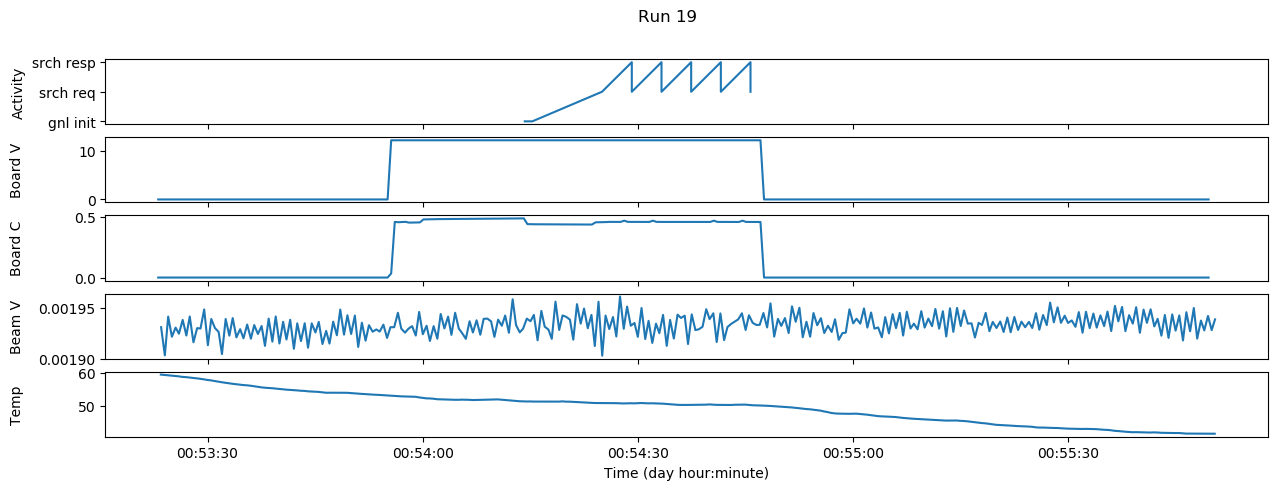

In [12]:
FSIZE = (15,5)

fig, axes = plt.subplots(5,1, sharex = True, figsize=FSIZE,dpi=100) 
print(fig, axes)

axes[0].set_yticks([-1,0,1])
axes[0].set_yticklabels(["gnl init","srch req", "srch resp"])

axes[-1].set_xlabel("Time (day hour:minute)")

axes[0].set_ylabel("Activity")
axes[1].set_ylabel("Board V")
axes[2].set_ylabel("Board C")
axes[3].set_ylabel("Beam V")
axes[4].set_ylabel("Temp")

axes[0].plot(gsi_ts, logs_marker)
axes[1].plot(troxel_ts, voltages)
axes[2].plot(troxel_ts, current)
axes[3].plot(troxel_beamvoltage_ts, beam_voltages)
axes[4].plot(troxel_temp_ts, temps)

#10
#axes[1].yaxis.set_label_coords(-0.103,0.5)
#axes[2].yaxis.set_label_coords(-0.103,0.5)

#15
axes[1].yaxis.set_label_coords(-0.07,0.5)
axes[2].yaxis.set_label_coords(-0.07,0.5)
axes[3].yaxis.set_label_coords(-0.07,0.5)
axes[4].yaxis.set_label_coords(-0.07,0.5)

fig.suptitle(fname)
fig.savefig("%s.jpg" % fname,dpi=100,quality=100)